**Links:**
- building model: https://machinelearningmastery.com/build-multi-layer-perceptron-neural-network-models-keras/
- tuning hyperparameters via GridSearch: https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/

**Do:**
- implement k-fold cross validation - then we can get rid of training & validation sets and just have training set
- attempt model with more inputs
- tune parameters with grid search (article)

# ANN-5 Model
- input = (present-day) PM10, WS, WD, RH, Temp
- output = daily change in SR

In [109]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.metrics import RootMeanSquaredError
from keras.wrappers.scikit_learn import KerasRegressor
from keras.optimizers import SGD, RMSprop

from keras.utils.vis_utils import plot_model
from ann_visualizer.visualize import ann_viz

In [94]:
# --- Get Data ---
model_data = pd.read_pickle('model_data.pkl')

In [95]:
# --- Split Data into Train and Test Sets ---

# define X, y
X = np.asarray(model_data[['X_temp', 'X_rh', 'X_ws', 'X_wd', 'X_pm10']])
y = np.asarray(model_data['y_sratio_change']).reshape(-1,1)

# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

# train: 85%, test: 15%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)

In [96]:
# --- Standardize Data ---

# fit scaler on training dataset
scalerx = MinMaxScaler().fit(X_train)
scalery = MinMaxScaler().fit(y_train)

# transform training dataset
X_train = scalerx.transform(X_train)
y_train = scalery.transform(y_train)
# transform test dataset
X_test = scalerx.transform(X_test)
y_test = scalery.transform(y_test)

In [ ]:
# NOTE: must transform standardized y back to original y with:
# scalery.inverse_transform(y_train)

### Tune Parameters via Grid Search
#### Parameters: epoch and batch size

In [124]:
# --- Function to Create Model ---
def create_model():
    # create model
    model = Sequential()
    model.add(Dense(20, input_dim=5, activation='tanh'))
    model.add(Dense(1, activation='linear'))
    
    # compile model
    model.compile(loss='mse', optimizer='sgd', metrics=[RootMeanSquaredError()])
    
    return model

# --- Tuning Parameters: epoch and batch size ---

# create model
model = KerasRegressor(build_fn=create_model, verbose=0)

# define the grid search parameters
batch_size = [10, 20, 40, 60, 80, 100]
epochs = [10, 50, 100]
param_grid = dict(batch_size=batch_size, epochs=epochs)

for _ in range(5):
    # perform grid search
    grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_root_mean_squared_error', n_jobs=-1, cv=5)
    grid_result = grid.fit(X_train, y_train)

    # summarize results
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with: %r" % (mean, stdev, param))
    print()

Best: -0.125164 using {'batch_size': 10, 'epochs': 100}
-0.146231 (0.009020) with: {'batch_size': 10, 'epochs': 10}
-0.126618 (0.011808) with: {'batch_size': 10, 'epochs': 50}
-0.125164 (0.010904) with: {'batch_size': 10, 'epochs': 100}
-0.151203 (0.012673) with: {'batch_size': 20, 'epochs': 10}
-0.127717 (0.013032) with: {'batch_size': 20, 'epochs': 50}
-0.128068 (0.012820) with: {'batch_size': 20, 'epochs': 100}
-0.161294 (0.027988) with: {'batch_size': 40, 'epochs': 10}
-0.150595 (0.026889) with: {'batch_size': 40, 'epochs': 50}
-0.136523 (0.016771) with: {'batch_size': 40, 'epochs': 100}
-0.159029 (0.015437) with: {'batch_size': 60, 'epochs': 10}
-0.155936 (0.014634) with: {'batch_size': 60, 'epochs': 50}
-0.136745 (0.011015) with: {'batch_size': 60, 'epochs': 100}
-0.190473 (0.046456) with: {'batch_size': 80, 'epochs': 10}
-0.161426 (0.020021) with: {'batch_size': 80, 'epochs': 50}
-0.138217 (0.007410) with: {'batch_size': 80, 'epochs': 100}
-0.162270 (0.027825) with: {'batch_size

In [106]:
# rmse %
.12 / y_train.mean() * 100

27.83729262527867

#### Optimal values:
- batch_size = 10, epochs = 100

#### Parameter: optimization algorithm
Fixed:
- batch_size = 10, epochs = 100

In [125]:
# --- Function to Create Model ---
def create_model(optimizer='sgd'):
    # create model
    model = Sequential()
    model.add(Dense(20, input_dim=5, activation='tanh'))
    model.add(Dense(1, activation='linear'))
    
    # compile model
    model.compile(loss='mse', optimizer=optimizer, metrics=[RootMeanSquaredError()])
    
    return model

# --- Tuning Parameters: optimizer ---

# create model
model = KerasRegressor(build_fn=create_model, epochs=100, batch_size=10, verbose=0)

# define the grid search parameters
optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
param_grid = dict(optimizer=optimizer)

for _ in range(5):
    # perform grid search
    grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_root_mean_squared_error', n_jobs=-1, cv=5)
    grid_result = grid.fit(X_train, y_train)

    # summarize results
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with: %r" % (mean, stdev, param))
    print()

Best: -0.124100 using {'optimizer': 'Adamax'}
-0.124589 (0.011168) with: {'optimizer': 'SGD'}
-0.126411 (0.011683) with: {'optimizer': 'RMSprop'}
-0.173160 (0.034370) with: {'optimizer': 'Adagrad'}
-0.483205 (0.206785) with: {'optimizer': 'Adadelta'}
-0.126703 (0.012992) with: {'optimizer': 'Adam'}
-0.124100 (0.011596) with: {'optimizer': 'Adamax'}
-0.125091 (0.010652) with: {'optimizer': 'Nadam'}

Best: -0.124437 using {'optimizer': 'Adamax'}
-0.126491 (0.013628) with: {'optimizer': 'SGD'}
-0.125242 (0.010480) with: {'optimizer': 'RMSprop'}
-0.167988 (0.013592) with: {'optimizer': 'Adagrad'}
-0.501096 (0.120701) with: {'optimizer': 'Adadelta'}
-0.126844 (0.007650) with: {'optimizer': 'Adam'}
-0.124437 (0.011981) with: {'optimizer': 'Adamax'}
-0.125975 (0.012228) with: {'optimizer': 'Nadam'}

Best: -0.124024 using {'optimizer': 'Adam'}
-0.124528 (0.010150) with: {'optimizer': 'SGD'}
-0.125043 (0.009119) with: {'optimizer': 'RMSprop'}
-0.145085 (0.010393) with: {'optimizer': 'Adagrad'}


#### Optimal value:
- optimizer = 'Adamax'

#### Now we go back and re-tune batch_size and epochs:
Fixed:
- optimizer = 'Adamax'

In [126]:
# --- Function to Create Model ---
def create_model():
    # create model
    model = Sequential()
    model.add(Dense(20, input_dim=5, activation='tanh'))
    model.add(Dense(1, activation='linear'))
    
    # compile model
    model.compile(loss='mse', optimizer='Adamax', metrics=[RootMeanSquaredError()])
    
    return model

# --- Tuning Parameters: epoch and batch size ---

# create model
model = KerasRegressor(build_fn=create_model, verbose=0)

# define the grid search parameters
batch_size = [10, 20, 40, 60, 80, 100]
epochs = [10, 50, 100]
param_grid = dict(batch_size=batch_size, epochs=epochs)

for _ in range(5):
    # perform grid search
    grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_root_mean_squared_error', n_jobs=-1, cv=5)
    grid_result = grid.fit(X_train, y_train)

    # summarize results
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with: %r" % (mean, stdev, param))
    print()

Best: -0.124172 using {'batch_size': 10, 'epochs': 50}
-0.150647 (0.011626) with: {'batch_size': 10, 'epochs': 10}
-0.124172 (0.010606) with: {'batch_size': 10, 'epochs': 50}
-0.124373 (0.011504) with: {'batch_size': 10, 'epochs': 100}
-0.159995 (0.026917) with: {'batch_size': 20, 'epochs': 10}
-0.130348 (0.012936) with: {'batch_size': 20, 'epochs': 50}
-0.124750 (0.011314) with: {'batch_size': 20, 'epochs': 100}
-0.195543 (0.040181) with: {'batch_size': 40, 'epochs': 10}
-0.148404 (0.016357) with: {'batch_size': 40, 'epochs': 50}
-0.130593 (0.011658) with: {'batch_size': 40, 'epochs': 100}
-0.193958 (0.039151) with: {'batch_size': 60, 'epochs': 10}
-0.144939 (0.019775) with: {'batch_size': 60, 'epochs': 50}
-0.138389 (0.010423) with: {'batch_size': 60, 'epochs': 100}
-0.198823 (0.050766) with: {'batch_size': 80, 'epochs': 10}
-0.153718 (0.009157) with: {'batch_size': 80, 'epochs': 50}
-0.149142 (0.018943) with: {'batch_size': 80, 'epochs': 100}
-0.198373 (0.031636) with: {'batch_size'

#### Optimal values (same!):
- batch_size = 10, epochs = 100

#### Parameter: activation function
Fixed:
- batch_size = 10, epochs = 100
- optimizer = 'Adamax'

In [128]:
# --- Function to Create Model ---
def create_model(activation='tanh'):
    # create model
    model = Sequential()
    model.add(Dense(20, input_dim=5, activation=activation))
    model.add(Dense(1, activation='linear'))
    
    # compile model
    model.compile(loss='mse', optimizer='Adamax', metrics=[RootMeanSquaredError()])
    
    return model

# --- Tuning Parameters: optimizer ---

# create model
model = KerasRegressor(build_fn=create_model, epochs=100, batch_size=10, verbose=0)

# define the grid search parameters
activation = ['tanh', 'sigmoid', 'elu', 'selu', 'exponential', 'linear']
param_grid = dict(activation=activation)

for _ in range(5):
    # perform grid search
    grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_root_mean_squared_error', n_jobs=-1, cv=5)
    grid_result = grid.fit(X_train, y_train)

    # summarize results
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with: %r" % (mean, stdev, param))
    print()

Best: -0.123155 using {'activation': 'linear'}
-0.124057 (0.011312) with: {'activation': 'tanh'}
-0.124460 (0.008507) with: {'activation': 'sigmoid'}
-0.124785 (0.011460) with: {'activation': 'elu'}
-0.125240 (0.011358) with: {'activation': 'selu'}
-0.124433 (0.010673) with: {'activation': 'exponential'}
-0.123155 (0.011429) with: {'activation': 'linear'}

Best: -0.123655 using {'activation': 'linear'}
-0.124517 (0.011710) with: {'activation': 'tanh'}
-0.127679 (0.011205) with: {'activation': 'sigmoid'}
-0.124683 (0.011864) with: {'activation': 'elu'}
-0.125317 (0.010749) with: {'activation': 'selu'}
-0.125649 (0.009248) with: {'activation': 'exponential'}
-0.123655 (0.012132) with: {'activation': 'linear'}

Best: -0.123310 using {'activation': 'linear'}
-0.125158 (0.012542) with: {'activation': 'tanh'}
-0.124321 (0.009942) with: {'activation': 'sigmoid'}
-0.124945 (0.011764) with: {'activation': 'elu'}
-0.124263 (0.009498) with: {'activation': 'selu'}
-0.125227 (0.010725) with: {'acti

#### Optimal value:
- activation = 'linear'

#### Parameter: weight initialization
Fixed:
- batch_size = 10, epochs = 100
- optimizer = 'Adamax'
- activation = 'linear'

In [130]:
# --- Function to Create Model ---
def create_model(init_mode='uniform'):
    # create model
    model = Sequential()
    model.add(Dense(20, input_dim=5, kernel_initializer=init_mode, activation='linear'))
    model.add(Dense(1, kernel_initializer=init_mode, activation='linear'))
    
    # compile model
    model.compile(loss='mse', optimizer='Adamax', metrics=[RootMeanSquaredError()])
    
    return model

# --- Tuning Parameters: optimizer ---

# create model
model = KerasRegressor(build_fn=create_model, epochs=100, batch_size=10, verbose=0)

# define the grid search parameters
init_mode = ['uniform', 'lecun_uniform', 'normal', 'zero', 'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform']
param_grid = dict(init_mode=init_mode)

for _ in range(5):
    # perform grid search
    grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_root_mean_squared_error', n_jobs=-1, cv=5)
    grid_result = grid.fit(X_train, y_train)

    # summarize results
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with: %r" % (mean, stdev, param))
    print()

Best: -0.123506 using {'init_mode': 'he_normal'}
-0.124193 (0.011155) with: {'init_mode': 'uniform'}
-0.124284 (0.011064) with: {'init_mode': 'lecun_uniform'}
-0.124318 (0.011619) with: {'init_mode': 'normal'}
-0.124144 (0.009453) with: {'init_mode': 'zero'}
-0.124236 (0.010852) with: {'init_mode': 'glorot_normal'}
-0.125370 (0.009316) with: {'init_mode': 'glorot_uniform'}
-0.123506 (0.011085) with: {'init_mode': 'he_normal'}
-0.125713 (0.012217) with: {'init_mode': 'he_uniform'}

Best: -0.123610 using {'init_mode': 'glorot_normal'}
-0.124094 (0.011411) with: {'init_mode': 'uniform'}
-0.123998 (0.010508) with: {'init_mode': 'lecun_uniform'}
-0.123965 (0.011329) with: {'init_mode': 'normal'}
-0.124146 (0.009492) with: {'init_mode': 'zero'}
-0.123610 (0.011232) with: {'init_mode': 'glorot_normal'}
-0.124141 (0.011705) with: {'init_mode': 'glorot_uniform'}
-0.123775 (0.010875) with: {'init_mode': 'he_normal'}
-0.127700 (0.016211) with: {'init_mode': 'he_uniform'}

Best: -0.123266 using {'

#### Optimal value:
- kernel_initializer = 'glorot_normal'

#### Parameter: # of neurons in the hidden layer
Fixed:
- batch_size = 10, epochs = 100
- optimizer = 'Adamax'
- activation = 'linear'
- kernel_initializer = 'glorot_normal'

In [131]:
# --- Function to Create Model ---
def create_model(neurons=4):
    # create model
    model = Sequential()
    model.add(Dense(neurons, input_dim=5, kernel_initializer='glorot_normal', activation='linear'))
    model.add(Dense(1, kernel_initializer='glorot_normal', activation='linear'))
    
    # compile model
    model.compile(loss='mse', optimizer='Adamax', metrics=[RootMeanSquaredError()])
    
    return model

# --- Tuning Parameters: optimizer ---

# create model
model = KerasRegressor(build_fn=create_model, epochs=100, batch_size=10, verbose=0)

# define the grid search parameters
neurons = [4, 6, 8, 10, 12, 14, 16, 18, 20, 22]
param_grid = dict(neurons=neurons)

for _ in range(5):
    # perform grid search
    grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_root_mean_squared_error', n_jobs=-1, cv=5)
    grid_result = grid.fit(X_train, y_train)

    # summarize results
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with: %r" % (mean, stdev, param))
    print()

Best: -0.123656 using {'neurons': 16}
-0.128772 (0.014397) with: {'neurons': 4}
-0.125114 (0.010786) with: {'neurons': 6}
-0.124365 (0.010799) with: {'neurons': 8}
-0.125708 (0.010992) with: {'neurons': 10}
-0.124431 (0.011923) with: {'neurons': 12}
-0.123895 (0.011365) with: {'neurons': 14}
-0.123656 (0.011622) with: {'neurons': 16}
-0.123851 (0.011432) with: {'neurons': 18}
-0.123699 (0.011004) with: {'neurons': 20}
-0.124074 (0.010145) with: {'neurons': 22}

Best: -0.124044 using {'neurons': 20}
-0.133544 (0.020216) with: {'neurons': 4}
-0.127262 (0.011502) with: {'neurons': 6}
-0.126496 (0.010891) with: {'neurons': 8}
-0.124321 (0.011556) with: {'neurons': 10}
-0.125419 (0.010809) with: {'neurons': 12}
-0.124194 (0.010463) with: {'neurons': 14}
-0.125137 (0.010966) with: {'neurons': 16}
-0.124271 (0.010203) with: {'neurons': 18}
-0.124044 (0.010838) with: {'neurons': 20}
-0.124694 (0.010790) with: {'neurons': 22}

Best: -0.122927 using {'neurons': 14}
-0.140009 (0.022243) with: {'n

#### Optimal value:
- neurons = 16

# Resulting Network:
- batch_size = 10, epochs = 100
- optimizer = 'Adamax'
- activation = 'linear'
- kernel_initializer = 'glorot_normal'
- neurons = 16

# First Try:

#### Parameters: learning rate, rho, and momentum
Fixed:
- batch_size = 10, epochs = 100
- optimizer = 'RMSprop'

In [112]:
# --- Function to Create Model ---
def create_model(learn_rate=0.001, rho=0.9, momentum=0.0):
    # create model
    model = Sequential()
    model.add(Dense(10, input_dim=5, activation='linear'))
    model.add(Dense(1, activation='sigmoid'))
    
    # compile model
    optimizer = RMSprop(learning_rate=learn_rate, rho=rho, momentum=momentum)
    model.compile(loss='mse', optimizer=optimizer, metrics=[RootMeanSquaredError()])
    
    return model

# --- Tuning Parameters: optimizer ---

# create model
model = KerasRegressor(build_fn=create_model, epochs=50, batch_size=40, verbose=0)

# define the grid search parameters
learn_rate = [0.001, 0.01, 0.1]
rho = [0.0, 0.2, 0.4, 0.6, 0.8, 0.9]
momentum = [0.0, 0.2, 0.4, 0.6, 0.8, 0.9]
param_grid = dict(learn_rate=learn_rate, rho=rho, momentum=momentum)

for _ in range(5):
    # perform grid search
    grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_root_mean_squared_error', n_jobs=-1, cv=5)
    grid_result = grid.fit(X_train, y_train)

    # summarize results
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with: %r" % (mean, stdev, param))
    print()

Best: -0.123174 using {'learn_rate': 0.001, 'momentum': 0.2, 'rho': 0.2}
-0.124375 (0.007904) with: {'learn_rate': 0.001, 'momentum': 0.0, 'rho': 0.0}
-0.125873 (0.012108) with: {'learn_rate': 0.001, 'momentum': 0.0, 'rho': 0.2}
-0.124734 (0.009191) with: {'learn_rate': 0.001, 'momentum': 0.0, 'rho': 0.4}
-0.124357 (0.010982) with: {'learn_rate': 0.001, 'momentum': 0.0, 'rho': 0.6}
-0.124651 (0.011048) with: {'learn_rate': 0.001, 'momentum': 0.0, 'rho': 0.8}
-0.125181 (0.010504) with: {'learn_rate': 0.001, 'momentum': 0.0, 'rho': 0.9}
-0.124724 (0.010185) with: {'learn_rate': 0.001, 'momentum': 0.2, 'rho': 0.0}
-0.123174 (0.010719) with: {'learn_rate': 0.001, 'momentum': 0.2, 'rho': 0.2}
-0.125712 (0.009751) with: {'learn_rate': 0.001, 'momentum': 0.2, 'rho': 0.4}
-0.125337 (0.010522) with: {'learn_rate': 0.001, 'momentum': 0.2, 'rho': 0.6}
-0.123720 (0.009972) with: {'learn_rate': 0.001, 'momentum': 0.2, 'rho': 0.8}
-0.124653 (0.010366) with: {'learn_rate': 0.001, 'momentum': 0.2, 'rh

Best: -0.122931 using {'learn_rate': 0.001, 'momentum': 0.9, 'rho': 0.2}
-0.125177 (0.010135) with: {'learn_rate': 0.001, 'momentum': 0.0, 'rho': 0.0}
-0.124382 (0.009877) with: {'learn_rate': 0.001, 'momentum': 0.0, 'rho': 0.2}
-0.123843 (0.009433) with: {'learn_rate': 0.001, 'momentum': 0.0, 'rho': 0.4}
-0.124771 (0.011480) with: {'learn_rate': 0.001, 'momentum': 0.0, 'rho': 0.6}
-0.125077 (0.009852) with: {'learn_rate': 0.001, 'momentum': 0.0, 'rho': 0.8}
-0.123880 (0.009004) with: {'learn_rate': 0.001, 'momentum': 0.0, 'rho': 0.9}
-0.124758 (0.010122) with: {'learn_rate': 0.001, 'momentum': 0.2, 'rho': 0.0}
-0.123717 (0.009811) with: {'learn_rate': 0.001, 'momentum': 0.2, 'rho': 0.2}
-0.126238 (0.011224) with: {'learn_rate': 0.001, 'momentum': 0.2, 'rho': 0.4}
-0.124309 (0.010745) with: {'learn_rate': 0.001, 'momentum': 0.2, 'rho': 0.6}
-0.123296 (0.009126) with: {'learn_rate': 0.001, 'momentum': 0.2, 'rho': 0.8}
-0.125812 (0.010712) with: {'learn_rate': 0.001, 'momentum': 0.2, 'rh

Best: -0.123254 using {'learn_rate': 0.001, 'momentum': 0.9, 'rho': 0.0}
-0.126186 (0.010760) with: {'learn_rate': 0.001, 'momentum': 0.0, 'rho': 0.0}
-0.125645 (0.010181) with: {'learn_rate': 0.001, 'momentum': 0.0, 'rho': 0.2}
-0.125339 (0.009445) with: {'learn_rate': 0.001, 'momentum': 0.0, 'rho': 0.4}
-0.126616 (0.011176) with: {'learn_rate': 0.001, 'momentum': 0.0, 'rho': 0.6}
-0.125274 (0.009866) with: {'learn_rate': 0.001, 'momentum': 0.0, 'rho': 0.8}
-0.125181 (0.009592) with: {'learn_rate': 0.001, 'momentum': 0.0, 'rho': 0.9}
-0.125674 (0.012470) with: {'learn_rate': 0.001, 'momentum': 0.2, 'rho': 0.0}
-0.124884 (0.009683) with: {'learn_rate': 0.001, 'momentum': 0.2, 'rho': 0.2}
-0.124403 (0.010015) with: {'learn_rate': 0.001, 'momentum': 0.2, 'rho': 0.4}
-0.124379 (0.011046) with: {'learn_rate': 0.001, 'momentum': 0.2, 'rho': 0.6}
-0.125742 (0.010749) with: {'learn_rate': 0.001, 'momentum': 0.2, 'rho': 0.8}
-0.123503 (0.009254) with: {'learn_rate': 0.001, 'momentum': 0.2, 'rh

Best: -0.123300 using {'learn_rate': 0.001, 'momentum': 0.0, 'rho': 0.4}
-0.124740 (0.008160) with: {'learn_rate': 0.001, 'momentum': 0.0, 'rho': 0.0}
-0.125918 (0.010884) with: {'learn_rate': 0.001, 'momentum': 0.0, 'rho': 0.2}
-0.123300 (0.009241) with: {'learn_rate': 0.001, 'momentum': 0.0, 'rho': 0.4}
-0.124115 (0.007903) with: {'learn_rate': 0.001, 'momentum': 0.0, 'rho': 0.6}
-0.125556 (0.009422) with: {'learn_rate': 0.001, 'momentum': 0.0, 'rho': 0.8}
-0.124716 (0.008987) with: {'learn_rate': 0.001, 'momentum': 0.0, 'rho': 0.9}
-0.125666 (0.009506) with: {'learn_rate': 0.001, 'momentum': 0.2, 'rho': 0.0}
-0.125651 (0.008831) with: {'learn_rate': 0.001, 'momentum': 0.2, 'rho': 0.2}
-0.124139 (0.009958) with: {'learn_rate': 0.001, 'momentum': 0.2, 'rho': 0.4}
-0.124591 (0.010447) with: {'learn_rate': 0.001, 'momentum': 0.2, 'rho': 0.6}
-0.125357 (0.010346) with: {'learn_rate': 0.001, 'momentum': 0.2, 'rho': 0.8}
-0.125314 (0.010044) with: {'learn_rate': 0.001, 'momentum': 0.2, 'rh

Best: -0.123305 using {'learn_rate': 0.001, 'momentum': 0.0, 'rho': 0.2}
-0.123954 (0.010210) with: {'learn_rate': 0.001, 'momentum': 0.0, 'rho': 0.0}
-0.123305 (0.010265) with: {'learn_rate': 0.001, 'momentum': 0.0, 'rho': 0.2}
-0.124934 (0.011033) with: {'learn_rate': 0.001, 'momentum': 0.0, 'rho': 0.4}
-0.124050 (0.010380) with: {'learn_rate': 0.001, 'momentum': 0.0, 'rho': 0.6}
-0.125306 (0.011339) with: {'learn_rate': 0.001, 'momentum': 0.0, 'rho': 0.8}
-0.124226 (0.009500) with: {'learn_rate': 0.001, 'momentum': 0.0, 'rho': 0.9}
-0.125298 (0.010470) with: {'learn_rate': 0.001, 'momentum': 0.2, 'rho': 0.0}
-0.124908 (0.010452) with: {'learn_rate': 0.001, 'momentum': 0.2, 'rho': 0.2}
-0.126029 (0.010817) with: {'learn_rate': 0.001, 'momentum': 0.2, 'rho': 0.4}
-0.125250 (0.012023) with: {'learn_rate': 0.001, 'momentum': 0.2, 'rho': 0.6}
-0.124500 (0.009106) with: {'learn_rate': 0.001, 'momentum': 0.2, 'rho': 0.8}
-0.125797 (0.009659) with: {'learn_rate': 0.001, 'momentum': 0.2, 'rh

#### Optimal values:
- learning_rate = 0.001
- momentum = 0.9
- rho = 0.2

#### Parameter: weight initialization
Fixed:
- batch_size = 40, epochs = 50
- optimizer = 'RMSprop'
    - learning_rate = 0.001
    - momentum = 0.9
    - rho = 0.2

In [114]:
# --- Function to Create Model ---
def create_model(init_mode='uniform'):
    # create model
    model = Sequential()
    model.add(Dense(10, input_dim=5, kernel_initializer=init_mode, activation='linear'))
    model.add(Dense(1, kernel_initializer=init_mode, activation='sigmoid'))
    
    # compile model
    optimizer = RMSprop(learning_rate=0.001, rho=0.9, momentum=0.0)
    model.compile(loss='mse', optimizer=optimizer, metrics=[RootMeanSquaredError()])
    
    return model

# --- Tuning Parameters: optimizer ---

# create model
model = KerasRegressor(build_fn=create_model, epochs=50, batch_size=40, verbose=0)

# define the grid search parameters
init_mode = ['uniform', 'lecun_uniform', 'normal', 'zero', 'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform']
param_grid = dict(init_mode=init_mode)

for _ in range(5):
    # perform grid search
    grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_root_mean_squared_error', n_jobs=-1, cv=5)
    grid_result = grid.fit(X_train, y_train)

    # summarize results
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with: %r" % (mean, stdev, param))
    print()

Best: -0.123272 using {'init_mode': 'glorot_uniform'}
-0.124305 (0.009534) with: {'init_mode': 'uniform'}
-0.124204 (0.008675) with: {'init_mode': 'lecun_uniform'}
-0.124120 (0.009457) with: {'init_mode': 'normal'}
-0.124234 (0.008992) with: {'init_mode': 'zero'}
-0.126012 (0.007278) with: {'init_mode': 'glorot_normal'}
-0.123272 (0.010353) with: {'init_mode': 'glorot_uniform'}
-0.125798 (0.006939) with: {'init_mode': 'he_normal'}
-0.127689 (0.009511) with: {'init_mode': 'he_uniform'}

Best: -0.123789 using {'init_mode': 'glorot_uniform'}
-0.124196 (0.009545) with: {'init_mode': 'uniform'}
-0.124525 (0.010849) with: {'init_mode': 'lecun_uniform'}
-0.124269 (0.009562) with: {'init_mode': 'normal'}
-0.124225 (0.008966) with: {'init_mode': 'zero'}
-0.125266 (0.011476) with: {'init_mode': 'glorot_normal'}
-0.123789 (0.010239) with: {'init_mode': 'glorot_uniform'}
-0.125983 (0.011329) with: {'init_mode': 'he_normal'}
-0.126612 (0.007973) with: {'init_mode': 'he_uniform'}

Best: -0.123482 us

#### Optimal values:
- kernel_initializer = 'glorot_uniform'

#### Parameter: activation function
Fixed:
- batch_size = 40, epochs = 50
- optimizer = 'RMSprop'
    - learning_rate = 0.001
    - momentum = 0.9
    - rho = 0.2
- kernel_initializer = 'glorot_uniform'

In [116]:
# --- Function to Create Model ---
def create_model(activation='linear'):
    # create model
    model = Sequential()
    model.add(Dense(10, input_dim=5, kernel_initializer='glorot_uniform', activation=activation))
    model.add(Dense(1, kernel_initializer='glorot_uniform', activation='sigmoid'))
    
    # compile model
    optimizer = RMSprop(learning_rate=0.001, rho=0.9, momentum=0.0)
    model.compile(loss='mse', optimizer=optimizer, metrics=[RootMeanSquaredError()])
    
    return model

# --- Tuning Parameters: optimizer ---

# create model
model = KerasRegressor(build_fn=create_model, epochs=50, batch_size=40, verbose=0)

# define the grid search parameters
activation = ['softmax', 'softplus', 'softsign', 'relu', 'tanh', 'sigmoid', 'elu', 'selu', 'exponential', 'linear']
param_grid = dict(activation=activation)

for _ in range(5):
    # perform grid search
    grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_root_mean_squared_error', n_jobs=-1, cv=5)
    grid_result = grid.fit(X_train, y_train)

    # summarize results
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with: %r" % (mean, stdev, param))
    print()

Best: -0.123534 using {'activation': 'softplus'}
-0.124090 (0.009340) with: {'activation': 'softmax'}
-0.123534 (0.009654) with: {'activation': 'softplus'}
-0.124971 (0.009153) with: {'activation': 'softsign'}
-0.126557 (0.009260) with: {'activation': 'relu'}
-0.125832 (0.009407) with: {'activation': 'tanh'}
-0.123966 (0.008723) with: {'activation': 'sigmoid'}
-0.125324 (0.009405) with: {'activation': 'elu'}
-0.126170 (0.009802) with: {'activation': 'selu'}
-0.125458 (0.008455) with: {'activation': 'exponential'}
-0.124216 (0.010341) with: {'activation': 'linear'}

Best: -0.123539 using {'activation': 'softsign'}
-0.124010 (0.009811) with: {'activation': 'softmax'}
-0.124967 (0.010566) with: {'activation': 'softplus'}
-0.123539 (0.009821) with: {'activation': 'softsign'}
-0.124770 (0.008824) with: {'activation': 'relu'}
-0.125032 (0.006869) with: {'activation': 'tanh'}
-0.124623 (0.008880) with: {'activation': 'sigmoid'}
-0.124949 (0.010042) with: {'activation': 'elu'}
-0.126302 (0.007

#### Optimal value:
- activation = 'elu'

#### Parameter: # of neurons in the hidden layer
Fixed:
- batch_size = 40, epochs = 50
- optimizer = 'RMSprop'
    - learning_rate = 0.001
    - momentum = 0.9
    - rho = 0.2
- kernel_initializer = 'glorot_uniform'
- activation = 'elu'

In [119]:
# --- Function to Create Model ---
def create_model(neurons=2):
    # create model
    model = Sequential()
    model.add(Dense(neurons, input_dim=5, kernel_initializer='glorot_uniform', activation='elu'))
    model.add(Dense(1, kernel_initializer='glorot_uniform', activation='sigmoid'))
    
    # compile model
    optimizer = RMSprop(learning_rate=0.001, rho=0.9, momentum=0.0)
    model.compile(loss='mse', optimizer=optimizer, metrics=[RootMeanSquaredError()])
    
    return model

# --- Tuning Parameters: optimizer ---

# create model
model = KerasRegressor(build_fn=create_model, epochs=50, batch_size=40, verbose=0)

# define the grid search parameters
neurons = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22]
param_grid = dict(neurons=neurons)

for _ in range(5):
    # perform grid search
    grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_root_mean_squared_error', n_jobs=-1, cv=5)
    grid_result = grid.fit(X_train, y_train)

    # summarize results
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with: %r" % (mean, stdev, param))
    print()

Best: -0.123116 using {'neurons': 16}
-0.125649 (0.008830) with: {'neurons': 2}
-0.127360 (0.010160) with: {'neurons': 4}
-0.125873 (0.011372) with: {'neurons': 6}
-0.123307 (0.009605) with: {'neurons': 8}
-0.123950 (0.011563) with: {'neurons': 10}
-0.125198 (0.010204) with: {'neurons': 12}
-0.124540 (0.010057) with: {'neurons': 14}
-0.123116 (0.010183) with: {'neurons': 16}
-0.124738 (0.010153) with: {'neurons': 18}
-0.123308 (0.010098) with: {'neurons': 20}
-0.123897 (0.010288) with: {'neurons': 22}

Best: -0.122842 using {'neurons': 20}
-0.126119 (0.010130) with: {'neurons': 2}
-0.125114 (0.006464) with: {'neurons': 4}
-0.124277 (0.010898) with: {'neurons': 6}
-0.125716 (0.010971) with: {'neurons': 8}
-0.125829 (0.009400) with: {'neurons': 10}
-0.124544 (0.009753) with: {'neurons': 12}
-0.123735 (0.008319) with: {'neurons': 14}
-0.124469 (0.009845) with: {'neurons': 16}
-0.123572 (0.009011) with: {'neurons': 18}
-0.122842 (0.010049) with: {'neurons': 20}
-0.124715 (0.009072) with: {

#### Optimal Value:
- neurons = 16, 20, 22

#### Now we will tune # of neurons together with batch_size and epochs

In [120]:
# --- Function to Create Model ---
def create_model(neurons=20):
    # create model
    model = Sequential()
    model.add(Dense(neurons, input_dim=5, kernel_initializer='glorot_uniform', activation='elu'))
    model.add(Dense(1, kernel_initializer='glorot_uniform', activation='sigmoid'))
    
    # compile model
    optimizer = RMSprop(learning_rate=0.001, rho=0.9, momentum=0.0)
    model.compile(loss='mse', optimizer=optimizer, metrics=[RootMeanSquaredError()])
    
    return model

# --- Tuning Parameters: optimizer ---

# create model
model = KerasRegressor(build_fn=create_model, verbose=0)

# define the grid search parameters
neurons = [16, 20, 22]
batch_size = [10, 20, 40, 60, 80, 100]
epochs = [10, 50, 100]
param_grid = dict(neurons=neurons, batch_size=batch_size, epochs=epochs)

for _ in range(5):
    # perform grid search
    grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_root_mean_squared_error', n_jobs=-1, cv=5)
    grid_result = grid.fit(X_train, y_train)

    # summarize results
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with: %r" % (mean, stdev, param))
    print()

Best: -0.122800 using {'batch_size': 100, 'epochs': 100, 'neurons': 16}
-0.125840 (0.009071) with: {'batch_size': 10, 'epochs': 10, 'neurons': 16}
-0.125159 (0.010397) with: {'batch_size': 10, 'epochs': 10, 'neurons': 20}
-0.124708 (0.009295) with: {'batch_size': 10, 'epochs': 10, 'neurons': 22}
-0.124236 (0.010828) with: {'batch_size': 10, 'epochs': 50, 'neurons': 16}
-0.123825 (0.009515) with: {'batch_size': 10, 'epochs': 50, 'neurons': 20}
-0.124277 (0.010467) with: {'batch_size': 10, 'epochs': 50, 'neurons': 22}
-0.123346 (0.010901) with: {'batch_size': 10, 'epochs': 100, 'neurons': 16}
-0.124337 (0.010176) with: {'batch_size': 10, 'epochs': 100, 'neurons': 20}
-0.124100 (0.010218) with: {'batch_size': 10, 'epochs': 100, 'neurons': 22}
-0.127936 (0.009883) with: {'batch_size': 20, 'epochs': 10, 'neurons': 16}
-0.125873 (0.010805) with: {'batch_size': 20, 'epochs': 10, 'neurons': 20}
-0.123599 (0.010086) with: {'batch_size': 20, 'epochs': 10, 'neurons': 22}
-0.123496 (0.009997) with

Best: -0.123150 using {'batch_size': 10, 'epochs': 50, 'neurons': 20}
-0.127243 (0.010783) with: {'batch_size': 10, 'epochs': 10, 'neurons': 16}
-0.126500 (0.008967) with: {'batch_size': 10, 'epochs': 10, 'neurons': 20}
-0.124485 (0.009014) with: {'batch_size': 10, 'epochs': 10, 'neurons': 22}
-0.124476 (0.010583) with: {'batch_size': 10, 'epochs': 50, 'neurons': 16}
-0.123150 (0.010692) with: {'batch_size': 10, 'epochs': 50, 'neurons': 20}
-0.123271 (0.010946) with: {'batch_size': 10, 'epochs': 50, 'neurons': 22}
-0.123743 (0.010823) with: {'batch_size': 10, 'epochs': 100, 'neurons': 16}
-0.124037 (0.010236) with: {'batch_size': 10, 'epochs': 100, 'neurons': 20}
-0.123697 (0.011149) with: {'batch_size': 10, 'epochs': 100, 'neurons': 22}
-0.126658 (0.011200) with: {'batch_size': 20, 'epochs': 10, 'neurons': 16}
-0.125871 (0.010147) with: {'batch_size': 20, 'epochs': 10, 'neurons': 20}
-0.125001 (0.009397) with: {'batch_size': 20, 'epochs': 10, 'neurons': 22}
-0.124712 (0.008979) with: 

Best: -0.122758 using {'batch_size': 40, 'epochs': 50, 'neurons': 20}
-0.124650 (0.010404) with: {'batch_size': 10, 'epochs': 10, 'neurons': 16}
-0.125080 (0.009972) with: {'batch_size': 10, 'epochs': 10, 'neurons': 20}
-0.123303 (0.011233) with: {'batch_size': 10, 'epochs': 10, 'neurons': 22}
-0.124219 (0.010883) with: {'batch_size': 10, 'epochs': 50, 'neurons': 16}
-0.124347 (0.009833) with: {'batch_size': 10, 'epochs': 50, 'neurons': 20}
-0.124101 (0.010998) with: {'batch_size': 10, 'epochs': 50, 'neurons': 22}
-0.123563 (0.010900) with: {'batch_size': 10, 'epochs': 100, 'neurons': 16}
-0.124420 (0.010110) with: {'batch_size': 10, 'epochs': 100, 'neurons': 20}
-0.123249 (0.010983) with: {'batch_size': 10, 'epochs': 100, 'neurons': 22}
-0.126062 (0.006798) with: {'batch_size': 20, 'epochs': 10, 'neurons': 16}
-0.126146 (0.010365) with: {'batch_size': 20, 'epochs': 10, 'neurons': 20}
-0.124869 (0.009414) with: {'batch_size': 20, 'epochs': 10, 'neurons': 22}
-0.123826 (0.010752) with: 

#### Optimal Values:
- neurons = 20
- batch_size = 40
- epochs = 50

#### Now we will go back and re-tune the parameters with discovered fixed values.

#### Parameter: 

Fixed:
- batch_size = 40, epochs = 50
- neurons = 20
- kernel_initializer = 'glorot_uniform'

Fixed (but not sure):
- optimizer = 'RMSprop'
    - learning_rate = 0.001
    - momentum = 0.9
    - rho = 0.2
- activation = 'elu'

# Later:

In [9]:
# --- Initializing Variables ---

# layers
#neurons_per_layer = 20
#input_dim = 5
#kernel_initializer = 'random_uniform'
#bias_initializer = 'zeros'
#activation_fn = 'tanh'

# compiling
#optimizer = 'adam'
#loss = 'mse'
#metrics = [RootMeanSquaredError()]

# training
#epochs = 60
#batch_size = 32

In [132]:
# --- Train Model ---
model = create_model(neurons=16)
model_fit = model.fit(X_train, y_train, batch_size = 10, epochs = 100)

Epoch 1/100
35/35 [==============================] - 0s 469us/step - loss: 0.1536 - root_mean_squared_error: 0.3872
Epoch 2/100
35/35 [==============================] - 0s 616us/step - loss: 0.0312 - root_mean_squared_error: 0.1762
Epoch 3/100
35/35 [==============================] - 0s 704us/step - loss: 0.0344 - root_mean_squared_error: 0.1848
Epoch 4/100
35/35 [==============================] - 0s 704us/step - loss: 0.0307 - root_mean_squared_error: 0.1752
Epoch 5/100
35/35 [==============================] - 0s 733us/step - loss: 0.0288 - root_mean_squared_error: 0.1694
Epoch 6/100
35/35 [==============================] - 0s 851us/step - loss: 0.0293 - root_mean_squared_error: 0.1708
Epoch 7/100
35/35 [==============================] - 0s 909us/step - loss: 0.0236 - root_mean_squared_error: 0.1533
Epoch 8/100
35/35 [==============================] - 0s 880us/step - loss: 0.0252 - root_mean_squared_error: 0.1587
Epoch 9/100
35/35 [==============================] - 0s 1ms/step - loss:

Text(0.5, 1.0, 'RMSE Across Epochs (%)')

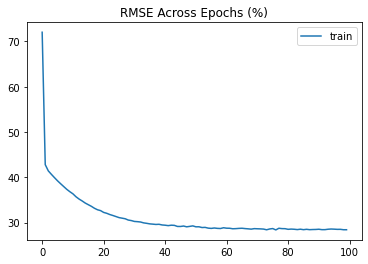

In [134]:
# --- Evaluate Model ---

# get rmse (%)
train_rmse = (model_fit.history['root_mean_squared_error'] / y_train.mean()) * 100
#val_rmse = (model_fit.history['val_root_mean_squared_error'] / y_val.mean()) * 100

# plot rmse across epochs
plt.plot(train_rmse, label='train')
#plt.plot(val_rmse, label='validation')
plt.legend()
plt.title('RMSE Across Epochs (%)')

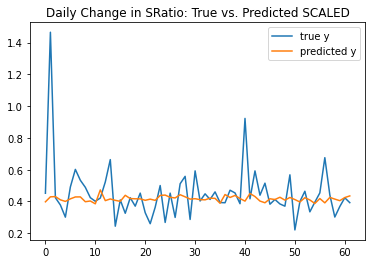

In [141]:
# --- Model Prediction ---

# calculate the loss values for input data
#model.evaluate(X_test, y_test)

# generate network output for input data
y_pred = model.predict(X_test)
plt.plot(y_test, label='true y')
plt.plot(y_pred, label='predicted y')
plt.legend()
plt.title('Daily Change in SRatio: True vs. Predicted SCALED');

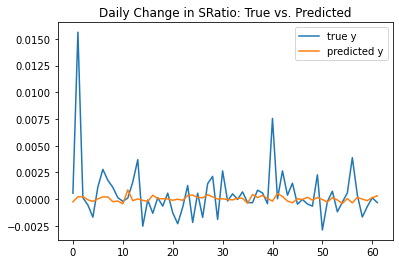

In [142]:
# inverse the scaled data
y_pred_og = scalery.inverse_transform(y_pred)
y_test_og = scalery.inverse_transform(y_test)
plt.plot(y_test_og, label='true y')
plt.plot(y_pred_og, label='predicted y')
plt.legend()
plt.title('Daily Change in SRatio: True vs. Predicted');

In [136]:
# --- Visualize Model ---
model.summary()

Model: "sequential_159"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_318 (Dense)            (None, 16)                96        
_________________________________________________________________
dense_319 (Dense)            (None, 1)                 17        
Total params: 113
Trainable params: 113
Non-trainable params: 0
_________________________________________________________________


In [137]:
ann_viz(model, title="Network Structure")